In [184]:
## imports
import sys, os, random, re, glob
import pandas as pd
import pprint as pp
#from functools import reduce

設定

In [185]:
## 処理設定
verbose = False

### LDA 用
## トピック数
n_topics = 9 # 30は多過ぎる？

## tSNE 用
## 実行前にサンプリングするかどうか
doc_fit_sampling = True

### DTM 構築: doc, term の設定
## doc
doc_type      = 'form'  # 変更不可
doc_attrs     = [ 'spell', 'sound' ]
doc_attr      = doc_attrs[0]
print(f"doc_attr: {doc_attr}")
## term
term_size     = 'character' # 出力用の名目変数
term_types    = re.split(r",\s+", "1gram, 2gram, 3gram, skippy2gram, skippy3gram")
term_type     = term_types[-1]
print(f"term_type: {term_type}")
## doc の長さの上限
max_doc_size  = 13
print(f"max_doc_size: {max_doc_size}")
## doc の長さの下限
min_doc_size  = 3
print(f"min_doc_size: {min_doc_size}")
## term の最低頻度
term_min_freq = 2
## 高頻度 term の濫用指標: 大きくし過ぎないように．terms の異なりが小さいので0.03 は十分に大きい
term_abuse_threshold = 0.005
## skippy n-gram の表記
gap_mark = "…"
## ngram を包括的にするかどうか
ngram_is_inclusive = True
## skippy n-gram の結合範囲
max_distance_val = round(max_doc_size * 0.8)
print(f"max_distance_val: {max_distance_val}")

doc_attr: spell
term_type: skippy3gram
max_doc_size: 13
min_doc_size: 3
max_distance_val: 10


# 言語の選別

In [186]:
## 言語の選別
select_languages = True
## 言語の割合の均等化
balanced = True
## 色分けで言語名の変わりに語族を使う
color_lang_family = True
## 英語をゲルマン語に含める
germanic_includes_english = False
## ルーマニア語をロマンス語に含める
romance_includes_romanian = False
## スラブ語属を設定する
use_slavic = False # russian, czech を一緒にするのは条件付き
## ルーマニア語をスラブ語に含める
slavic_includes_romanian = False


In [187]:
##綴り解析で使える言語
## arabic, bengali, chinese, czech, esperanto, english, finnish, french,
## galician, german, greek, hebrew, hungarian, icelandic, irish, italian,
## japanese, romanian, russian, spanish, swahili, turkish, welsh

##音声解析で使える言語
## arabic, chinese, english, esperanto, french, german, icelandic, japanese, korean, spanish, swahili

import re
spell_set0 = "arabic, bengali, chinese, czech, esperato, english, finnish, french, \
    galician, german, greek, hebrew, hungarian, icelandic, irish, italian, japanese, korean, \
        romanian, russian, spanish, swahili, turkish, welsh"
spell_set1 = "arabic, czech, hebrew, english, esperanto, finnish, french, german, greek, \
    hungarian, icelandic, irish, romanian, russian, italian, spanish, swahili, turkish, welsh"
spell_set2 = "english, esperanto, french, finnish, german, hungarian, icelandic, irish, italian, \
    spanish, swahili, turkish, welsh"
spell_set3 = "english, esperanto, finnish, german, hungarian, irish, swahili, turkish, welsh"
#
sound_set0 = "arabic, chinese, english, esperato, french, german, icelandic, japanese, korean, spanish, swahili"
sound_set1 = "arabic, english, esperanto, french, german, icelandic, japanese, korean, spanish, swahili"
##
selected_langs = re.split(r",\s*", spell_set1)
print(f"selected {len(selected_langs)} languages:\n{selected_langs}")

selected 19 languages:
['arabic', 'czech', 'hebrew', 'english', 'esperanto', 'finnish', 'french', 'german', 'greek', 'hungarian', 'icelandic', 'irish', 'romanian', 'russian', 'italian', 'spanish', 'swahili', 'turkish', 'welsh']


In [188]:
## 全言語をカバーできる色パレットの用意
import plotly
color_palette = plotly.colors.qualitative.Light24

In [189]:
## load data to process
from pathlib import Path
import pprint as pp
wd = Path(".")
dirs = [ x for x in wd.iterdir() if x.is_dir() and not x.match(r"plot*") ]
if verbose:
    print(f"The following {len(dirs)} directories are potential targets:")
    pp.pprint(dirs)

## list up files in target directory 
wd = Path(".")
target_dir = "data-words" # can be changed
target_files = sorted(list(wd.glob(f"{target_dir}/*.csv")))
#
print(f"\n{target_dir} contains {len(target_files)} files to process")
if verbose:
    pp.pprint(target_files)


data-words contains 34 files to process


In [190]:
import pandas as pd
## データ型の辞書
types = re.split(r",\s+", "spell, sound")
type_settings = { t : 0 for t in types }
print(type_settings)

## 言語名の辞書
#lang_name_list = "arabic, bengali, chinese, czech, english, esperanto, \
#    finnish, french, galician, greek, german, hebrew, hungarian, \
#    icelandic, irish, italian, japanese, korean, romanian, russian, spanish, swahili, turkish, welsh"
#langs = re.split(r",\s*", lang_name_list)
langs = selected_langs
lang_settings = { lang : 0 for lang in langs }
print(f"{len(lang_settings.keys())} langs are available")
print(lang_settings)

## 辞書と統合
settings = { **type_settings, **lang_settings }
print(settings)

{'spell': 0, 'sound': 0}
19 langs are available
{'arabic': 0, 'czech': 0, 'hebrew': 0, 'english': 0, 'esperanto': 0, 'finnish': 0, 'french': 0, 'german': 0, 'greek': 0, 'hungarian': 0, 'icelandic': 0, 'irish': 0, 'romanian': 0, 'russian': 0, 'italian': 0, 'spanish': 0, 'swahili': 0, 'turkish': 0, 'welsh': 0}
{'spell': 0, 'sound': 0, 'arabic': 0, 'czech': 0, 'hebrew': 0, 'english': 0, 'esperanto': 0, 'finnish': 0, 'french': 0, 'german': 0, 'greek': 0, 'hungarian': 0, 'icelandic': 0, 'irish': 0, 'romanian': 0, 'russian': 0, 'italian': 0, 'spanish': 0, 'swahili': 0, 'turkish': 0, 'welsh': 0}


In [191]:
## Obtain data from files
check = False
setting_keys = list(settings.keys())
print(f"target setting_keys: {setting_keys}")
d_parts = [ ]
for lang in lang_settings.keys():
    local_settings = settings.copy()
    if check:
        print(f"processing: {lang}")
    try:
        ## ファイル単位で処理
        for f in [ f for f in target_files if lang.capitalize() in str(f) ]:
            print(f"reading: {f}")
            
            # 言語名の指定
            local_settings[lang] = 1
            
            # 型名の指定
            for key in type_settings.keys():
                if key in str(f):
                    local_settings[key] = 1
                else:
                    local_settings[key] = 0 # この変更を見落とさないように
            
            # ファイル処理
            try:
                data = pd.read_csv(f, encoding = 'utf-8', sep = ",", on_bad_lines = 'skip') # Crucially, ...= skip
                if check:
                    print(data)
                #dfx = pd.DataFrame(data, columns = setting_keys)
                dfx = pd.DataFrame(data, columns = ['form', 'freq'])
                for key in settings.keys():
                    dfx[key] = local_settings[key]
                    if check:
                        print(dfx)
                d_parts.append(dfx)
            except FileNotFoundError:
                pass
    except IndexError:
        pass
#
if verbose:
    d_parts

target setting_keys: ['spell', 'sound', 'arabic', 'czech', 'hebrew', 'english', 'esperanto', 'finnish', 'french', 'german', 'greek', 'hungarian', 'icelandic', 'irish', 'romanian', 'russian', 'italian', 'spanish', 'swahili', 'turkish', 'welsh']
reading: data-words/base-sound-Arabic-r0-1k-mc.csv
reading: data-words/base-spell-Arabic-r0-1k-mc.csv
reading: data-words/base-spell-Czech-r0-1k-mc.csv
reading: data-words/base-spell-Hebrew-r0-1k-mc.csv
reading: data-words/base-sound-English-r6e-original.csv
reading: data-words/base-spell-English-r6e-original.csv
reading: data-words/base-sound-Esperanto-r0-1k-mc-sorted.csv
reading: data-words/base-spell-Esperanto-r0-orginal.csv
reading: data-words/base-spell-Finnish-r0-1k-mc.csv
reading: data-words/base-sound-French-r0-1k-mc.csv
reading: data-words/base-sound-French-r0-opendic-s900.csv
reading: data-words/base-spell-French-r0-1k-mc.csv
reading: data-words/base-sound-German-r1a-original.csv
reading: data-words/base-spell-German-r1a-original.csv
re

In [192]:
## データ統合
raw_df = pd.concat(d_parts)
raw_df

,form,freq,spell,sound,arabic,czech,hebrew,english,esperanto,finnish,...,hungarian,icelandic,irish,romanian,russian,italian,spanish,swahili,turkish,welsh
0,kamaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ʔanaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,lahu,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ʔan,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,huːa,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,trwyn,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
996,lluosog,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
997,dicter,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
998,hawliad,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [193]:
## 言語名= language の列を追加
check = False
language_vals = [ ]
for i, row in raw_df.iterrows():
    if check:
        print(row)
    for j, lang in enumerate(langs):
        if check:
            print(f"{i}: {lang}")
        if row[lang] == 1:
            language_vals.append(lang)
if verbose:
    print(language_vals)
    len(language_vals)
#
raw_df['language'] = language_vals
raw_df

,form,freq,spell,sound,arabic,czech,hebrew,english,esperanto,finnish,...,icelandic,irish,romanian,russian,italian,spanish,swahili,turkish,welsh,language
0,kamaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,arabic
1,ʔanaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,arabic
2,lahu,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,arabic
3,ʔan,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,arabic
4,huːa,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,arabic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,trwyn,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,welsh
996,lluosog,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,welsh
997,dicter,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,welsh
998,hawliad,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,welsh


In [194]:
## 言語族 family 列の追加
# germanic
if germanic_includes_english:
    germanic_langs = [ 'english', 'german', 'icelandic' ]
else:
    germanic_langs = [ 'german', 'icelandic' ]
# celtic
celtic_langs       = [ 'irish', 'welsh' ]
# romance
if romance_includes_romanian:
    romance_langs  = [ 'esperanto', 'galician', 'french', 'romanian', 'italian', 'spanish' ]
else:
    romance_langs  = [ 'esperanto', 'galician', 'french', 'italian', 'spanish' ]
# slavic
if use_slavic:
    if slavic_includes_romanian:
        slavic_langs   = [ 'czech', 'romanian', 'russian' ]
    else:
        slavic_langs   = [ 'czech', 'russian' ]
else:
    slavic_langs = [ ]
#
check = False
family_vals = [ ]
for i, row in raw_df.iterrows():
    if check:
        print(row)
    lang = row['language']
    if check:
        print(f"{i}: {lang}")
    # romance langs
    if lang in celtic_langs:
        family_vals.append('celtic')
    # romance langs
    elif lang in romance_langs:
        family_vals.append('romance')
    # germanic langs
    elif lang in germanic_langs:
        family_vals.append('germanic')
    # slavic langs
    elif lang in slavic_langs:
        family_vals.append('slavic')
    # all others
    else:
        family_vals.append(lang)
#
if verbose:
    print(family_vals)
    len(family_vals)
#
raw_df['family'] = family_vals
raw_df

,form,freq,spell,sound,arabic,czech,hebrew,english,esperanto,finnish,...,irish,romanian,russian,italian,spanish,swahili,turkish,welsh,language,family
0,kamaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,arabic,arabic
1,ʔanaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,arabic,arabic
2,lahu,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,arabic,arabic
3,ʔan,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,arabic,arabic
4,huːa,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,arabic,arabic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,trwyn,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,welsh,celtic
996,lluosog,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,welsh,celtic
997,dicter,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,welsh,celtic
998,hawliad,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,welsh,celtic


In [195]:
## 文字数の列を追加
raw_df['size'] = [ len(x) for x in raw_df[doc_type] ]
raw_df

,form,freq,spell,sound,arabic,czech,hebrew,english,esperanto,finnish,...,romanian,russian,italian,spanish,swahili,turkish,welsh,language,family,size
0,kamaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,5
1,ʔanaː,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,5
2,lahu,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,4
3,ʔan,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,3
4,huːa,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,trwyn,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,5
996,lluosog,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,7
997,dicter,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,6
998,hawliad,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,7


In [196]:
## 解析データの型指定
print(f"doc_attr: {doc_attr}")
raw_df = raw_df[raw_df[doc_attr] == 1]
raw_df

doc_attr: spell


,form,freq,spell,sound,arabic,czech,hebrew,english,esperanto,finnish,...,romanian,russian,italian,spanish,swahili,turkish,welsh,language,family,size
0,كما,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,3
1,أنا,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,3
2,له,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,2
3,أن,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,2
4,هو,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,trwyn,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,5
996,lluosog,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,7
997,dicter,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,6
998,hawliad,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,7


In [197]:
## 言語の選別
if select_languages:
    df_new = [ ]
    for lang in selected_langs:
        df_new.append(raw_df[raw_df[lang] == 1])
    raw_df = pd.concat(df_new)
#
raw_df

,form,freq,spell,sound,arabic,czech,hebrew,english,esperanto,finnish,...,romanian,russian,italian,spanish,swahili,turkish,welsh,language,family,size
0,كما,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,3
1,أنا,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,3
2,له,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,2
3,أن,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,2
4,هو,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,arabic,arabic,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,trwyn,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,5
996,lluosog,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,7
997,dicter,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,6
998,hawliad,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,7


/var/folders/yh/c68mhtcj6yn7qsl201kw_7zw0000gn/T/ipykernel_49088/1424494094.py:10: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



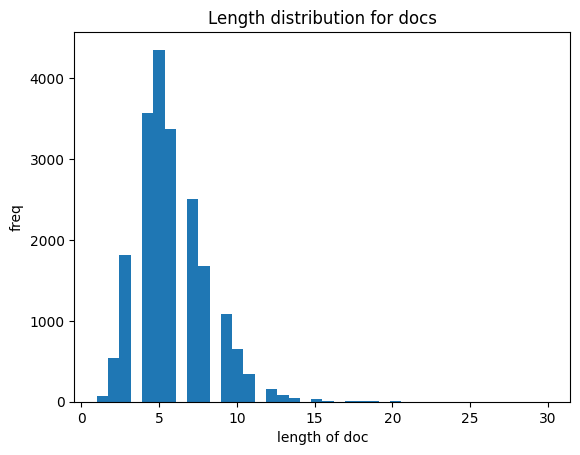

In [198]:
## 文字数の分布
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(raw_df['size'], bins = 40)
ax.set_xlabel('length of doc')
ax.set_ylabel('freq')
plt.title(f"Length distribution for docs")
fig.show()

データを長さで濾過

In [199]:
## 長過ぎる語の除外 
print(f"max doc size: {max_doc_size}")
original_size = len(raw_df)
raw_df = raw_df[raw_df['size'] <= max_doc_size]
max_filtered_size = len(raw_df)
print(f"{original_size - max_filtered_size} cases removed due to max_doc_size")

## 短過ぎる語の除外
print(f"min doc size: {min_doc_size}")
raw_df = raw_df[raw_df['size'] >= min_doc_size]
min_filtered_size = len(raw_df)
print(f"{max_filtered_size - min_filtered_size} cases removed due to min_doc_size")
#
print(f"{original_size - min_filtered_size} cases removed in total")

max doc size: 13
104 cases removed due to max_doc_size
min doc size: 3
601 cases removed due to min_doc_size
705 cases removed in total


In [200]:
## 結果の検査 1
for type in types:
    print(raw_df[type].value_counts(sort = True))

spell
1    19615
Name: count, dtype: int64
sound
0    19615
Name: count, dtype: int64


In [201]:
## 結果の検査 2
for lang in langs:
    print(raw_df[lang].value_counts(sort = True).sort_index())

arabic
0    18671
1      944
Name: count, dtype: int64
czech
0    18662
1      953
Name: count, dtype: int64
hebrew
0    18698
1      917
Name: count, dtype: int64
english
0    15397
1     4218
Name: count, dtype: int64
esperanto
0    18933
1      682
Name: count, dtype: int64
finnish
0    18633
1      982
Name: count, dtype: int64
french
0    18651
1      964
Name: count, dtype: int64
german
0    18839
1      776
Name: count, dtype: int64
greek
0    18645
1      970
Name: count, dtype: int64
hungarian
0    18673
1      942
Name: count, dtype: int64
icelandic
0    18791
1      824
Name: count, dtype: int64
irish
0    18686
1      929
Name: count, dtype: int64
romanian
0    19615
Name: count, dtype: int64
russian
0    18664
1      951
Name: count, dtype: int64
italian
0    18650
1      965
Name: count, dtype: int64
spanish
0    18649
1      966
Name: count, dtype: int64
swahili
0    18915
1      700
Name: count, dtype: int64
turkish
0    18652
1      963
Name: count, dtype: int64
welsh


英語事例の割合補正

In [202]:
## 統合: 割合補正を適用
eng_reduct_factor = 0.2
if balanced:
    eng_df = raw_df[raw_df['english'] == 1]
    non_eng_df = raw_df[raw_df['english'] == 0]
    eng_reduced_df = eng_df.sample(round(len(eng_df) * eng_reduct_factor))
    raw_df = pd.concat([eng_reduced_df, non_eng_df])
#
raw_df

,form,freq,spell,sound,arabic,czech,hebrew,english,esperanto,finnish,...,romanian,russian,italian,spanish,swahili,turkish,welsh,language,family,size
2566,observe,1.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,english,english,7
960,deliver,1.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,english,english,7
394,bloyer,1.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,english,english,6
3086,reference,1.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,english,english,9
1972,interfere,1.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,english,english,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,trwyn,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,5
996,lluosog,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,7
997,dicter,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,6
998,hawliad,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,welsh,celtic,7


In [203]:
## 結果の検査 3
for lang in langs:
    print(raw_df[lang].value_counts().sort_index())

arabic
0    15297
1      944
Name: count, dtype: int64
czech
0    15288
1      953
Name: count, dtype: int64
hebrew
0    15324
1      917
Name: count, dtype: int64
english
0    15397
1      844
Name: count, dtype: int64
esperanto
0    15559
1      682
Name: count, dtype: int64
finnish
0    15259
1      982
Name: count, dtype: int64
french
0    15277
1      964
Name: count, dtype: int64
german
0    15465
1      776
Name: count, dtype: int64
greek
0    15271
1      970
Name: count, dtype: int64
hungarian
0    15299
1      942
Name: count, dtype: int64
icelandic
0    15417
1      824
Name: count, dtype: int64
irish
0    15312
1      929
Name: count, dtype: int64
romanian
0    16241
Name: count, dtype: int64
russian
0    15290
1      951
Name: count, dtype: int64
italian
0    15276
1      965
Name: count, dtype: int64
spanish
0    15275
1      966
Name: count, dtype: int64
swahili
0    15541
1      700
Name: count, dtype: int64
turkish
0    15278
1      963
Name: count, dtype: int64
welsh


# 解析

In [204]:
## 順序のランダマイズし，基本データを決定
import sklearn.utils
df = sklearn.utils.shuffle(raw_df)

DTM 構築の準備

In [205]:
## ngram の追加
import sys
sys.path.append('..')

import re
import ngrams
import importlib
importlib.reload(ngrams)
import ngrams_skippy

bases = df[doc_type]

In [206]:
## 1gram 列の追加
unigrams = ngrams.gen_unigrams(bases, sep = r"", check = False)
unigrams = [ [ u for u in L if len(u) > 0 ] for L in unigrams ]
if verbose:
    random.sample(unigrams, 5)
#
df['1gram'] = unigrams
df

,form,freq,spell,sound,arabic,czech,hebrew,english,esperanto,finnish,...,russian,italian,spanish,swahili,turkish,welsh,language,family,size,1gram
520,boyut,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,turkish,turkish,5,"[b, o, y, u, t]"
712,musí,1.0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,czech,czech,4,"[m, u, s, í]"
562,רגל,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,hebrew,hebrew,3,"[ר, ג, ל]"
879,pulcino,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,italian,romance,7,"[p, u, l, c, i, n, o]"
139,סיבה,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,hebrew,hebrew,4,"[ס, י, ב, ה]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,έκταση,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,greek,greek,6,"[έ, κ, τ, α, σ, η]"
232,talán,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,hungarian,hungarian,5,"[t, a, l, á, n]"
163,eyðimörk,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,icelandic,germanic,8,"[e, y, ð, i, m, ö, r, k]"
633,maliyet,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,turkish,turkish,7,"[m, a, l, i, y, e, t]"


In [207]:
## 2gram列の追加
bigrams = ngrams.gen_bigrams(bases, sep = r"", check = False)

## 包括的 2gram の作成
if ngram_is_inclusive:
    bigrams = [ [*b, *u] for b, u in zip(bigrams, unigrams) ]
#
if verbose:
    print(random.sample(bigrams, 3))

In [208]:
df['2gram'] = bigrams
if verbose:
    df

In [209]:
## 3gram列の追加
trigrams = ngrams.gen_trigrams(bases, sep = r"", check = False)

## 包括的 3gram の作成
if ngram_is_inclusive:
    trigrams = [ [ *t, *b ] for t, b in  zip(trigrams, bigrams) ]
#
if verbose:
    print(random.sample(trigrams, 3))

In [210]:
df['3gram'] = trigrams
if verbose:
    df

In [211]:
## skippy 2grams の生成
import ngrams_skippy
skippy_2grams = [ ngrams_skippy.gen_skippy_bigrams(x, missing_mark = gap_mark,
                                                    max_distance = max_distance_val, check = False)
                  for x in df['1gram'] ]

## 包括的 skippy 2-grams の生成
if ngram_is_inclusive:
    for i, b2 in enumerate(skippy_2grams):
        b2.extend(unigrams[i])
#
if verbose:
    random.sample(skippy_2grams, 3)

In [212]:
## skippy 2gram 列の追加
df['skippy2gram'] = skippy_2grams
df

,form,freq,spell,sound,arabic,czech,hebrew,english,esperanto,finnish,...,swahili,turkish,welsh,language,family,size,1gram,2gram,3gram,skippy2gram
520,boyut,1,1,0,0,0,0,0,0,0,...,0,1,0,turkish,turkish,5,"[b, o, y, u, t]","[bo, oy, yu, ut, b, o, y, u, t]","[boy, oyu, yut, bo, oy, yu, ut, b, o, y, u, t]","[bo, b…y, b…u, b…t, oy, o…u, o…t, yu, y…t, ut,..."
712,musí,1.0,1,0,0,1,0,0,0,0,...,0,0,0,czech,czech,4,"[m, u, s, í]","[mu, us, sí, m, u, s, í]","[mus, usí, mu, us, sí, m, u, s, í]","[mu, m…s, m…í, us, u…í, sí, m, u, s, í]"
562,רגל,1,1,0,0,0,1,0,0,0,...,0,0,0,hebrew,hebrew,3,"[ר, ג, ל]","[רג, גל, ר, ג, ל]","[רגל, רג, גל, ר, ג, ל]","[רג, ר…ל, גל, ר, ג, ל]"
879,pulcino,1,1,0,0,0,0,0,0,0,...,0,0,0,italian,romance,7,"[p, u, l, c, i, n, o]","[pu, ul, lc, ci, in, no, p, u, l, c, i, n, o]","[pul, ulc, lci, cin, ino, pu, ul, lc, ci, in, ...","[pu, p…l, p…c, p…i, p…n, p…o, ul, u…c, u…i, u…..."
139,סיבה,1,1,0,0,0,1,0,0,0,...,0,0,0,hebrew,hebrew,4,"[ס, י, ב, ה]","[סי, יב, בה, ס, י, ב, ה]","[סיב, יבה, סי, יב, בה, ס, י, ב, ה]","[סי, ס…ב, ס…ה, יב, י…ה, בה, ס, י, ב, ה]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,έκταση,1,1,0,0,0,0,0,0,0,...,0,0,0,greek,greek,6,"[έ, κ, τ, α, σ, η]","[έκ, κτ, τα, ασ, ση, έ, κ, τ, α, σ, η]","[έκτ, κτα, τασ, αση, έκ, κτ, τα, ασ, ση, έ, κ,...","[έκ, έ…τ, έ…α, έ…σ, έ…η, κτ, κ…α, κ…σ, κ…η, τα..."
232,talán,1,1,0,0,0,0,0,0,0,...,0,0,0,hungarian,hungarian,5,"[t, a, l, á, n]","[ta, al, lá, án, t, a, l, á, n]","[tal, alá, lán, ta, al, lá, án, t, a, l, á, n]","[ta, t…l, t…á, t…n, al, a…á, a…n, lá, l…n, án,..."
163,eyðimörk,1,1,0,0,0,0,0,0,0,...,0,0,0,icelandic,germanic,8,"[e, y, ð, i, m, ö, r, k]","[ey, yð, ði, im, mö, ör, rk, e, y, ð, i, m, ö,...","[eyð, yði, ðim, imö, mör, örk, ey, yð, ði, im,...","[ey, e…ð, e…i, e…m, e…ö, e…r, e…k, yð, y…i, y…..."
633,maliyet,1,1,0,0,0,0,0,0,0,...,0,1,0,turkish,turkish,7,"[m, a, l, i, y, e, t]","[ma, al, li, iy, ye, et, m, a, l, i, y, e, t]","[mal, ali, liy, iye, yet, ma, al, li, iy, ye, ...","[ma, m…l, m…i, m…y, m…e, m…t, al, a…i, a…y, a…..."


In [213]:
## skippy 3grams の生成
import ngrams_skippy
skippy_3grams = [ ngrams_skippy.gen_skippy_trigrams(x, missing_mark = gap_mark,
                                                         max_distance = max_distance_val, check = False)
                  for x in df['1gram'] ]

## 包括的 skippy 3-grams の生成
if ngram_is_inclusive:
    for i, t2 in enumerate(skippy_3grams):
        t2.extend(skippy_2grams[i])
#
if verbose:
    random.sample(skippy_3grams, 3)

In [214]:
## skippy 3gram 列の追加
df['skippy3gram'] = skippy_3grams
df

,form,freq,spell,sound,arabic,czech,hebrew,english,esperanto,finnish,...,turkish,welsh,language,family,size,1gram,2gram,3gram,skippy2gram,skippy3gram
520,boyut,1,1,0,0,0,0,0,0,0,...,1,0,turkish,turkish,5,"[b, o, y, u, t]","[bo, oy, yu, ut, b, o, y, u, t]","[boy, oyu, yut, bo, oy, yu, ut, b, o, y, u, t]","[bo, b…y, b…u, b…t, oy, o…u, o…t, yu, y…t, ut,...","[boy, bo…u, bo…t, b…yu, b…y…t, b…ut, oyu, oy…t..."
712,musí,1.0,1,0,0,1,0,0,0,0,...,0,0,czech,czech,4,"[m, u, s, í]","[mu, us, sí, m, u, s, í]","[mus, usí, mu, us, sí, m, u, s, í]","[mu, m…s, m…í, us, u…í, sí, m, u, s, í]","[mus, mu…í, m…sí, usí, mu, m…s, m…í, us, u…í, ..."
562,רגל,1,1,0,0,0,1,0,0,0,...,0,0,hebrew,hebrew,3,"[ר, ג, ל]","[רג, גל, ר, ג, ל]","[רגל, רג, גל, ר, ג, ל]","[רג, ר…ל, גל, ר, ג, ל]","[רגל, רג, ר…ל, גל, ר, ג, ל]"
879,pulcino,1,1,0,0,0,0,0,0,0,...,0,0,italian,romance,7,"[p, u, l, c, i, n, o]","[pu, ul, lc, ci, in, no, p, u, l, c, i, n, o]","[pul, ulc, lci, cin, ino, pu, ul, lc, ci, in, ...","[pu, p…l, p…c, p…i, p…n, p…o, ul, u…c, u…i, u…...","[pul, pu…c, pu…i, pu…n, pu…o, p…lc, p…l…i, p…l..."
139,סיבה,1,1,0,0,0,1,0,0,0,...,0,0,hebrew,hebrew,4,"[ס, י, ב, ה]","[סי, יב, בה, ס, י, ב, ה]","[סיב, יבה, סי, יב, בה, ס, י, ב, ה]","[סי, ס…ב, ס…ה, יב, י…ה, בה, ס, י, ב, ה]","[סיב, סי…ה, ס…בה, יבה, סי, ס…ב, ס…ה, יב, י…ה, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,έκταση,1,1,0,0,0,0,0,0,0,...,0,0,greek,greek,6,"[έ, κ, τ, α, σ, η]","[έκ, κτ, τα, ασ, ση, έ, κ, τ, α, σ, η]","[έκτ, κτα, τασ, αση, έκ, κτ, τα, ασ, ση, έ, κ,...","[έκ, έ…τ, έ…α, έ…σ, έ…η, κτ, κ…α, κ…σ, κ…η, τα...","[έκτ, έκ…α, έκ…σ, έκ…η, έ…τα, έ…τ…σ, έ…τ…η, έ…..."
232,talán,1,1,0,0,0,0,0,0,0,...,0,0,hungarian,hungarian,5,"[t, a, l, á, n]","[ta, al, lá, án, t, a, l, á, n]","[tal, alá, lán, ta, al, lá, án, t, a, l, á, n]","[ta, t…l, t…á, t…n, al, a…á, a…n, lá, l…n, án,...","[tal, ta…á, ta…n, t…lá, t…l…n, t…án, alá, al…n..."
163,eyðimörk,1,1,0,0,0,0,0,0,0,...,0,0,icelandic,germanic,8,"[e, y, ð, i, m, ö, r, k]","[ey, yð, ði, im, mö, ör, rk, e, y, ð, i, m, ö,...","[eyð, yði, ðim, imö, mör, örk, ey, yð, ði, im,...","[ey, e…ð, e…i, e…m, e…ö, e…r, e…k, yð, y…i, y…...","[eyð, ey…i, ey…m, ey…ö, ey…r, ey…k, e…ði, e…ð…..."
633,maliyet,1,1,0,0,0,0,0,0,0,...,1,0,turkish,turkish,7,"[m, a, l, i, y, e, t]","[ma, al, li, iy, ye, et, m, a, l, i, y, e, t]","[mal, ali, liy, iye, yet, ma, al, li, iy, ye, ...","[ma, m…l, m…i, m…y, m…e, m…t, al, a…i, a…y, a…...","[mal, ma…i, ma…y, ma…e, ma…t, m…li, m…l…y, m…l..."


DTM 構築

In [215]:
## LDA 構築の基になる document-term matrix (dtm) を構築
from gensim.corpora.dictionary import Dictionary
bots = df[term_type] # 後で参照するので変数化しておく
diction = Dictionary(bots)

## 結果の確認
print(diction)

Dictionary<106679 unique tokens: ['b', 'bo', 'boy', 'bo…t', 'bo…u']...>


In [216]:
## diction の濾過
import copy
diction_copy = copy.deepcopy(diction)

## filter適用: 実は諸刃の刃で，token数が少ない時には適用しない方が良い
print(f"min freq filter: {term_min_freq}")
print(f"abuse filter: {term_abuse_threshold}")

apply_filter = True
if apply_filter:
    diction_copy.filter_extremes(no_below = term_min_freq, no_above = term_abuse_threshold)

## check
print(diction_copy)

min freq filter: 2
abuse filter: 0.005
Dictionary<56116 unique tokens: ['boy', 'bo…t', 'bo…u', 'b…u', 'b…ut']...>


In [217]:
## Corpus (gensim の用語では corpus) の構築
corpus = [ diction.doc2bow(bot) for bot in bots ]

## check
check = True
if verbose:
    sample_n = 5
    print(random.sample(corpus, sample_n))
#
print(f"Number of documents: {len(corpus)}")

Number of documents: 16241


LDA モデルの構築

In [218]:
## LDA モデルの構築
from gensim.models import LdaModel
print(f"Building LDA model with n_topics: {n_topics}")
lda = LdaModel(corpus, id2word = diction, num_topics = n_topics, alpha = 0.01)
print(lda) # print(..)しないと中身が見れない

Building LDA model with n_topics: 9


LdaModel<num_terms=106679, num_topics=9, decay=0.5, chunksize=2000>


In [219]:
%%capture --no-display

## LDA のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = 30 # topic ごとに表示する term 数の指定
topic_dfs = [ ]
for topic in range(n_topics):
    terms = [ ]
    for i, prob in lda.get_topic_terms(topic, topn = n_terms):
        terms.append(diction.id2token[ int(i) ])
    #
    topic_dfs.append(pd.DataFrame([terms], index = [ f'topic {topic+1}' ]))
#
topic_term_df = pd.concat(topic_dfs)

## Table で表示
topic_term_df.T

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9
0,i,т,a,g,a,e,f,o,s
1,s,α,l,n,r,r,ا,t,h
2,a,и,a…a,d,u,i,ו,e,a
3,o,о,n,y,c,er,ל,n,t
4,l,е,k,e,i,e…e,ل,s,c
5,k,ο,a…n,u,t,n,ר,p,s…a
6,m,ε,i,a,n,re,ה,m,e
7,i…i,а,a…i,l,ur,l,י,e…t,ch
8,a…s,κ,la,j,c…a,e…r,ر,r,n
9,s…i,τ,al,w,c…i,o,ي,k,d


LDAvis の実行

In [220]:
%%capture --no-display

## pyLDAvis を使った結果 LDA の可視化: 階層クラスタリングより詳しい
import pyLDAvis
installed_version = pyLDAvis.__version__
print(f"installed_version: {installed_version}")
if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
#
pyLDAvis.enable_notebook()
#
lda_used     = lda
corpus_used  = corpus
diction_used = diction

## 実行パラメター: MMDS かtSNEを選ぶと "JSON object is too complex" error を回避できる 
use_MMDS  = True
use_tSNE  = False
if use_MMDS:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'mmds',
                            n_jobs = 1, sort_topics = False)
elif use_tSNE:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis)
## topic を表わす円の重なりが多いならn_topics が多過ぎる可能性がある．
## ただし2Dで重なっていても，3Dなら重なっていない可能性もある

In [221]:
## LDA がD に対して生成した topics の弁別性を確認
## 得られたtopics を確認
topic_dist = lda.get_topics()
if verbose:
    topic_dist

In [222]:
## 検査 1: topic ごとに分布の和を取る
print(topic_dist.sum(axis = 1))

[0.99999994 1.0000001  1.         1.0000002  0.9999999  1.
 0.99999994 0.99999994 1.0000001 ]


In [223]:
## 検査 2: 総和を求める: n_topics にほぼ等しいなら正常
print(topic_dist.sum())

8.999998


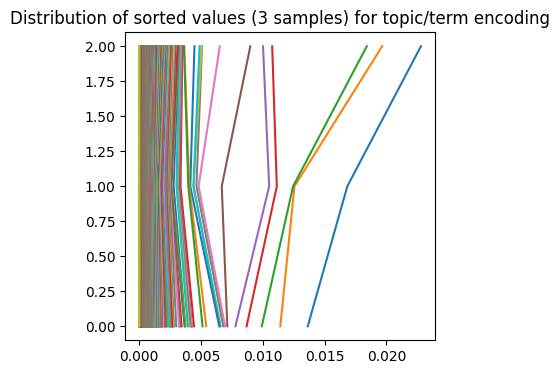

In [224]:
## term エンコード値の分布を確認
import matplotlib.pyplot as plt
plt.figure(figsize = (4,4))
sampling_rate = 0.3
df_size = len(topic_dist)
sample_n = round(df_size * sampling_rate)
topic_sampled = random.sample(list(topic_dist), sample_n)

T = sorted([ sorted(x, reverse = True) for x in topic_sampled ])
plt.plot(T, range(len(T)))
plt.title(f"Distribution of sorted values ({sample_n} samples) for topic/term encoding")
plt.show()

In [225]:
## tSNE を使った topics のグループ化 (3D)
from sklearn.manifold import TSNE
import numpy as np

## tSNE のパラメターを設定
## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
top_perplexity_reduct_rate = 0.3
perplexity_val = round(len(topic_dist) * top_perplexity_reduct_rate)
topic_tSNE_3d = TSNE(n_components = 3, random_state = 0, perplexity = perplexity_val, n_iter = 1000)

## データに適用
top_tSNE_3d_fitted = topic_tSNE_3d.fit_transform(np.array(topic_dist))

In [226]:
## Plotlyを使って tSNE の結果の可視化 (3D)
import plotly.graph_objects as go
top_fitted = top_tSNE_3d_fitted
fig = go.Figure(data = [go.Scatter3d(
        x = top_fitted[:,0], y = top_fitted[:,1], z = top_fitted[:,2],
                                     mode = 'markers')
                                     ])

## 3D 散布図にラベルを追加する処理は未実装
title_val = f"tSNE 3D view of topics in LDA (#topics: {n_topics}, doc: {doc_attr}, term: {term_type})"
fig.update_layout(autosize = False,
                  width = 600, height = 600, title = title_val)
fig.show()

# doc 分類

In [227]:
## 構築した LDA モデルを使って文(書)を分類する

## パラメター
ntopics = n_topics # LDA の構築の最に指定した値を使う
check    = False
encoding = [ ]
for i, row in df.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[term_type]
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc = lda.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check:
        print(f"enc: {enc}")
    encoding.append(enc)
#
len(encoding)

16241

In [228]:
## enc 列の追加
df['enc'] = [ list(map(lambda x: x[1], y)) for y in encoding ]
if verbose:
    df['enc']

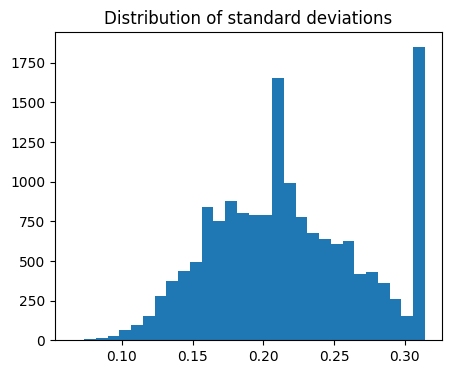

In [229]:
## エンコーディングのstd の分布を見る
import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize = (5,4))
plt.hist([ np.std(x) for x in df['enc'] ], bins = 30)

plt.title("Distribution of standard deviations")
plt.show()

In [230]:
## doc のエンコーディング

## 一様分布の事例を除外
import numpy as np
print(f"{len(df)} instances before filtering")

check = False
doc_enc = df['enc']
max_std = max([ np.std(x) for x in doc_enc])
if check:
    print(f"std max: {max_std}")

min_std = min([ np.std(x) for x in doc_enc])
if check:
    print(f"std min: {min_std}")

first_min_std = list(sorted(set([ np.std(x) for x in doc_enc])))[-0]
print(f"std 1st min: {first_min_std}")

second_min_std = list(sorted(set([ np.std(x) for x in doc_enc])))[-1]
print(f"std 2nd min: {second_min_std}")

16241 instances before filtering
std 1st min: 0.0649833157658577
std 2nd min: 0.31413987278938293


In [231]:
## df_filtered の定義
import numpy as np

## 閾値は2番目に小さい値より小さく最小値よりは大きな値であるべき
std_threshold = second_min_std / 4 # 穏健な値を得るために4で割った
print(f"std_threshold: {std_threshold}")

## Rっぽい次のコードは通らない
#df_filtered = df[ df['encoding'] > std_threshold ]
## 通るのは次のコード: Creating a list of True/False and apply it to DataFrame 
std_tested = [ False if np.std(x) < std_threshold else True for x in df['enc'] ]
df_filtered = df[ std_tested ]
#
print(f"Filtering leaves {len(df_filtered)} instances: ({len(df) - len(df_filtered)} instances removed)")

std_threshold: 0.07853496819734573


Filtering leaves 16234 instances: (7 instances removed)


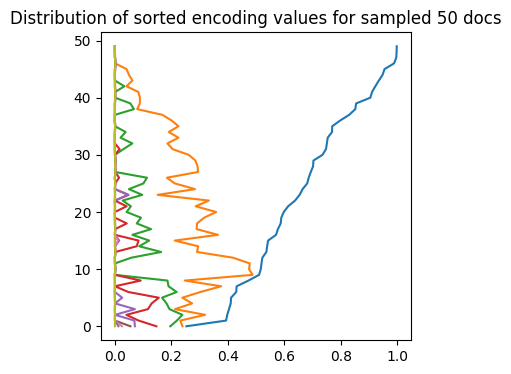

In [232]:
## doc エンコード値の分布を確認
sample_n = 50
E = sorted([ sorted(x, reverse = True) for x in df_filtered['enc'].sample(sample_n) ])
plt.figure(figsize = (4,4))
plt.plot(E, range(len(E)))
plt.title(f"Distribution of sorted encoding values for sampled {sample_n} docs")
plt.show()

In [233]:
len(df_filtered['language'])

16234

In [234]:
df_filtered['language'].value_counts(sort = True).sort_index()

language
arabic       944
czech        953
english      843
esperanto    681
finnish      982
french       964
german       776
greek        970
hebrew       917
hungarian    942
icelandic    823
irish        926
italian      965
russian      951
spanish      966
swahili      700
turkish      962
welsh        969
Name: count, dtype: int64

tSNE 用の事例サンプリング

In [235]:
## tSNE 用の事例サンプリング = tSNE_df の定義
doc_fit_sampling_rate = 0.1
if doc_fit_sampling:
    doc_fit_df_original = df_filtered.copy()
    sample_n = round(len(doc_fit_df_original) * doc_fit_sampling_rate)
    doc_fit_df = doc_fit_df_original.sample(sample_n)
    print(f"doc_fit_df has {len(doc_fit_df)} rows after sampling")
else:
    doc_fit_df = df_filtered

doc_fit_df has 1623 rows after sampling


In [236]:
doc_fit_df.columns

Index(['form', 'freq', 'spell', 'sound', 'arabic', 'czech', 'hebrew',
       'english', 'esperanto', 'finnish', 'french', 'german', 'greek',
       'hungarian', 'icelandic', 'irish', 'romanian', 'russian', 'italian',
       'spanish', 'swahili', 'turkish', 'welsh', 'language', 'family', 'size',
       '1gram', '2gram', '3gram', 'skippy2gram', 'skippy3gram', 'enc'],
      dtype='object')

In [237]:
doc_fit_df['language'].value_counts(sort = True).sort_index()

language
arabic       105
czech         99
english       93
esperanto     64
finnish       94
french       102
german        51
greek         99
hebrew       102
hungarian     95
icelandic     91
irish         91
italian       92
russian       98
spanish       91
swahili       66
turkish       89
welsh        101
Name: count, dtype: int64

In [238]:
doc_fit_df['family'].value_counts(sort = True).sort_index()

family
arabic       105
celtic       192
czech         99
english       93
finnish       94
germanic     142
greek         99
hebrew       102
hungarian     95
romance      349
russian       98
swahili       66
turkish       89
Name: count, dtype: int64

tSNE の結果の可視化 (3D)

In [239]:
## tSNE の結果の可視化: Plotly を使った 3D 描画
import numpy as np
from sklearn.manifold import TSNE as tSNE

import plotly.express as pex
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## tSNE のパラメターを設定
perplexity_max_val = round(len(doc_fit_df)/4)
print(f"perplexity_max_val: {perplexity_max_val}")
#perplexity_increment = 120
divider = 5
perplexity_increment = round(perplexity_max_val/divider)
print(f"perplexity_increment: {perplexity_increment}")

## tSNE を段階的に実行
early_exit = False
for step, perplexity_val in enumerate(range(5, perplexity_max_val, perplexity_increment)):
    ## 早期終了の判定
    if early_exit:
        if step > 0:
            continue
    ## tSNE 事例の生成
    tSNE_3d_varied = tSNE(n_components = 3, random_state = 0, perplexity = perplexity_val,
                          n_iter = 1000)

    ## データに適用
    doc_enc = np.array(list(doc_fit_df['enc']))
    doc_tSNE_3d_varied = tSNE_3d_varied.fit_transform(doc_enc)

    ## 色分けの単位を選択
    if color_lang_family:
        colored_var = 'family'
    else:
        colored_var = 'language'
    T = zip(doc_tSNE_3d_varied[:,0], doc_tSNE_3d_varied[:,1], doc_tSNE_3d_varied[:,2],
            doc_fit_df[colored_var]) # zip(..)が必要
    dfx = pd.DataFrame(T, columns = ['D1', 'D2', 'D3', colored_var])
    ## 作図
    fig = go.Figure()
    for lang in np.unique(df[colored_var]):
        part = dfx[dfx[colored_var] == lang]
        fig.add_trace(
            go.Scatter3d(
                x = part['D1'], y = part['D2'], z = part['D3'],
                name = lang, mode = 'markers', marker = dict(size = 4),
                marker_colorscale = color_palette, # worked??
                showlegend = True
            )
        )
    ## 題の指定
    title_val = f"tSNE 3D map (ppl: {perplexity_val}) of {len(doc_fit_df)} '{doc_attr}'s via LDA ({n_topics} topics, {term_type})"
    fig.update_layout(title = dict(text = title_val),
                      autosize = False, width = 600, height = 600)
    fig.show()

perplexity_max_val: 406
perplexity_increment: 81


In [240]:
## 必要に応じて adjustText を道入
#!pip install -U adjustText

tSNE の結果の可視化 (2D)

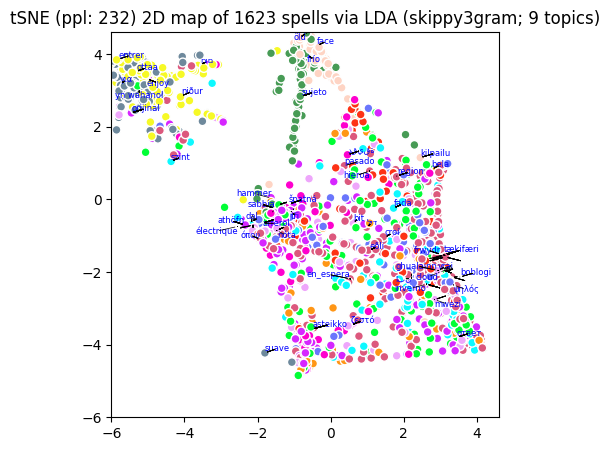

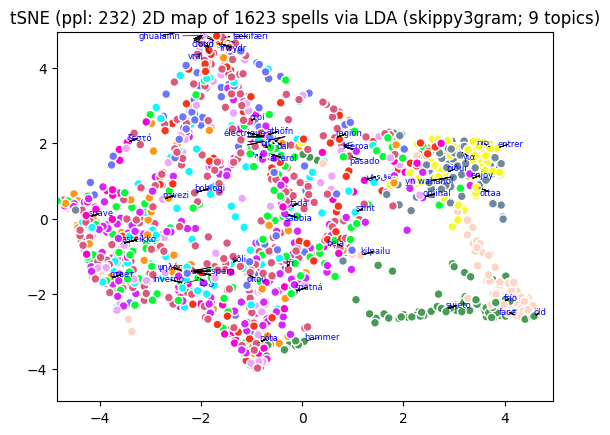

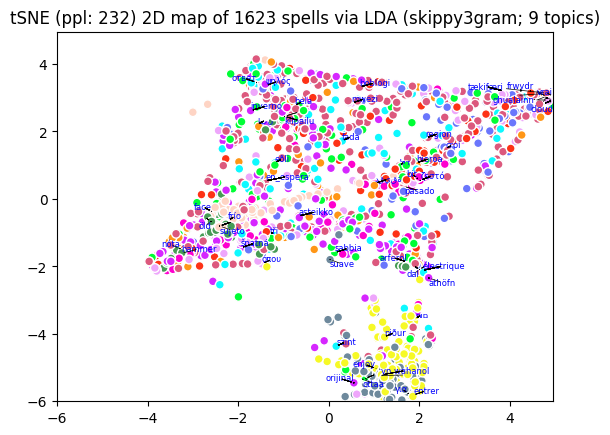

In [245]:
## tSNE の結果の可視化 (2D)
#import seaborn as sns
import numpy as np
import plotly
import plotly.express as pex
import matplotlib.pyplot as plt
from adjustText import adjust_text

## 次の設定は arabic が文字化けする
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある

## tSNE 事例の生成
ppl_divider = 7
perplexity_selected = round(len(doc_fit_df)/ppl_divider)
tSNE_3d = tSNE(n_components = 3, random_state = 0,
               perplexity = perplexity_selected, n_iter = 1000)

## データに適用
doc_enc = np.array(list(doc_fit_df['enc']))
doc_tSNE_3d = tSNE_3d.fit_transform(doc_enc)

## 色分けの単位を選択
if color_lang_family:
    colored_var = 'family' # 一部の言語を celtic, germanic, romance, slavic 属に統合
else:
    colored_var = 'language' # 言語名そのまま
#
S = zip(doc_tSNE_3d[:,0], doc_tSNE_3d[:,1], doc_tSNE_3d[:,2], doc_fit_df[colored_var]) # zip(..)が必要
df = pd.DataFrame(S, columns = ['D1', 'D2', 'D3', colored_var])

## 描画
plt.figure(figsize = (5, 5))
plt.set_colors = pex.colors.qualitative.Plotly
#
lab_sampling_rate = 0.03
lab_sample_n = round(len(doc_fit_df) * lab_sampling_rate)
sampled_keys = [ doc[:max_doc_size] for doc in random.sample(list(doc_fit_df[doc_type]), lab_sample_n) ]    

check = False
early_exit = False
for step, roll in enumerate([ np.roll([0,1,2], -i) for i in range(0,3) ]):
    ## 早期停止の判定
    if early_exit:
        if step > 0:
            continue
    ## 通常処理
    if check:
        print(roll)
    X, Y = df.iloc[:, roll[0]], df.iloc[:, roll[1]]
    gmax = max(X.max(), Y.max())
    gmin = min(X.min(), Y.min())
    plt.xlim(gmin, gmax)
    plt.ylim(gmin, gmax)

    ## 配色
    colormap = color_palette # == pex.colors.qualitative.Light24
    lang_list = list(set(doc_fit_df[colored_var]))
    cmapped = [ colormap[lang_list.index(lang)] for lang in df[colored_var] ]
    
    ## 作図
    scatter = plt.scatter(X, Y, s = 40, c = cmapped, edgecolors = 'w')

    ## 文字を表示する事例のサンプリング
    texts = [ ]
    ## labels の生成
    for x, y, s in zip(X, Y, sampled_keys):
        texts.append(plt.text(x, y, s, size = 7, color = 'blue'))
        ## label に repel を追加: adjustText package の導入が必要
        adjust_text(texts,
                #force_points = 0.2,
                ## Comment out the following line if you get AttributionError
                force_text = (.1, .2), expand_points = (1, 1), expand_text = (1, 1),
                arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    #
    plt.title(f"tSNE (ppl: {perplexity_selected}) 2D map of {len(doc_fit_df)} {doc_attr}s via LDA ({term_type}; {n_topics} topics)")
    #plt.legend(df['language'])
    plt.show()

階層クラスタリングのための部分サンプリングの追加

In [242]:
## 階層クラスタリングのための事例のサンプリング
hc_sampling_rate = 0.1 # 大きくし過ぎると図が見にくい
df_size = len(doc_fit_df)
hc_sample_n = round(df_size * hc_sampling_rate)
doc_hc_df = doc_fit_df.sample(hc_sample_n)
##
print(f"{hc_sample_n} rows are sampled")
doc_hc_df[colored_var].value_counts(sort = True).sort_index()

162 rows are sampled


family
arabic        8
celtic       25
czech        11
english       7
finnish       7
germanic      7
greek        11
hebrew       11
hungarian    12
romance      35
russian       5
swahili      12
turkish      11
Name: count, dtype: int64

階層クラスタリングの実行

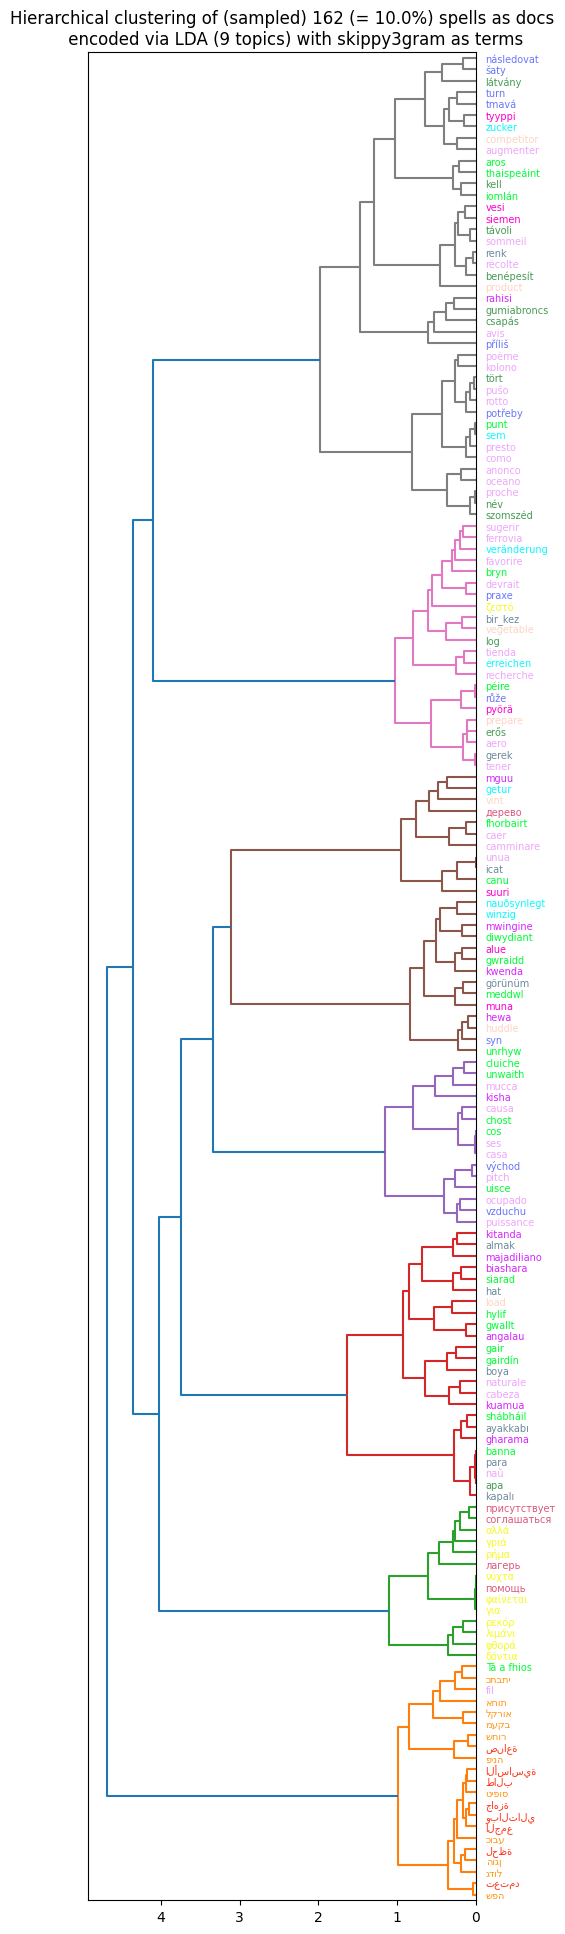

In [243]:
## doc 階層クラスタリングの実行
import numpy as np
import plotly
import matplotlib.pyplot as plt
## 次の設定は arabic, bengali が文字化けする
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある

## 描画サイズの指定
plt.figure(figsize = (5, round(len(doc_hc_df) * 0.15))) # This needs to be run here, before dendrogram construction.

## 事例ラベルの生成
label_vals = [ x[:max_doc_size] for x in list(doc_hc_df[doc_type]) ] # truncate doc keys

## 樹状分岐図の作成
from scipy.cluster.hierarchy import dendrogram, linkage

## 距離行列の生成
doc_hc_enc = list(doc_hc_df['enc'])
doc_linkage = linkage(doc_hc_enc, method = 'ward', metric = 'euclidean')
dendrogram(doc_linkage, orientation = 'left', labels = label_vals, leaf_font_size = 7)

## 描画
plt.title(f"Hierarchical clustering of (sampled) {len(doc_hc_df)} (= {100 * hc_sampling_rate}%) {doc_attr}s as docs\n \
    encoded via LDA ({n_topics} topics) with {term_type} as terms")

## ラベルに language に対応する色を付ける
lang_colors = { lang_name : i for i, lang_name in enumerate(np.unique(doc_hc_df[colored_var])) }
ax = plt.gca()
for ticker in ax.get_ymajorticklabels():
    form = ticker.get_text()
    row = doc_hc_df.loc[doc_hc_df[doc_type] == form]
    lang = row[colored_var].to_string().split()[-1] # trick
    try:
        lang_id = lang_colors[lang]
    except (TypeError, KeyError):
        print(f"color encoding error at: {lang}")
    #
    ticker.set_color(color_palette[lang_id])
#
plt.show()